# Intro to ML
## Selección de modelo y ajuste de hiper-parametros
---

En la sesión anterior vimos cómo usar la librería *de facto* para machine learning en python: `sklearn`.

En la sesión de hoy hablaremos de como las funcionalidades avanzadas de `sklearn` nos facilitan tanto la elección de modelos cómo su validación.

<div class="panel panel-success">
    <div class='panel-heading'>
    <h4>Empecemos</h4>
    </div>
    <div class='panel-body'>
    <ol type="A">
    <li>Selección de Modelos</li>
    <li>Ajuste de hiper-parámetros</li>
</ol>
    

## 1. Selección de Modelos
---

Los algoritmos de ML son herramientas muy potentes que nos permiten tanto ganar información no accesible a primera vista y, además, realizar modelos sobre los datos de forma que podamos hacer predicciones sobre nuevas observaciones.

A la hora de encarar un modelado predictivo, tenemos a nuestro haber un abanico muy amplio de modelos sobre los que elegir. La pregunta es: ¿cómo elijo un modelo?

### 1.1 Bies y varianza

Cómo bien sabéis a estas alturas, si nos dan una serie de atributos (*features*) $X = x_1, ..., x_n$ y un objetivo asociado (*target*) $y = y_1, ...y_n$, existe una función **real** $f(x)$ que nos permite modelar los datos de forma que $y = f(x) + \epsilon$, dónde $\epsilon$ es ruido con $\mu = 0$ y $var = \sigma^2$

Lo que queremos conseguir es un modelo, al que llamaremos $\hat{f}(x)$ que **aproxime** la función real lo mejor posible. Sucede que independientemente del modelo de ML que seleccionemos para aproximarnos a la función **real** podemos descomponer el **error** que comete nuestro modelo $\hat{y}$ sobre nuevas observaciones $x_{test}$ en tres componentes distintas:

$ Err(x) = \mathbb{E} \left[ \left( y_{test} - \hat{y} \right)^2 \right] = \left(E[\hat{f}(x)]-f(x)\right)^2 + E\left[\left(\hat{f}(x)-E[\hat{f}(x)]\right)^2\right] +\sigma_e^2$

* **Bias (sesgo)**

$E[\hat{f}(x)]-f(x)$

La diferencia entre el valor predicho por el modelo y el valor real.

Respecto al modelado, puede interpretarse como los supuestos de simplificación que hace un modelo para facilitar el aprendizaje de la función objetivo.

* Low bias: Pocos supuestos sobre la forma de los datos, más flexibles: Decission trees, knn, ...
* High bias: Simplificaciones sobre la forma de los datos, menos flexibles: Linear models


* **Varianza**

$E\left[\left(\hat{f}(x)-E[\hat{f}(x)]\right)^2\right]$

El error producido debido a la sensibilidad del modelo con respecto a los datos de entreno. Imagina que de un set de datos extraemos de forma aleatoria dos subgrupos de entreno. Idealmente, las predicciones del modelo no deberían cambiar mucho de un set de entreno a otro. Esto significaría que el modelo que hemos entrenado está haciendo un buen trabajo haciendo el mapeo de las variables de entrada a y salida.

Podemos dividir los distintos algoritmos de ML segun como le afectan los cambios en los datos de entreno:

* Low Variance: Pequeños cambios en las estimaciones predichas: Linear models
* High Variance: Grandes cambios en las estimaciones predichas: Decission trees, knn, ...

### 1.2 Compromiso entre bies y varianza

Como hemos visto, los modelos paramétricos, tipo los lineales, son modelos con un alto bies y una baja varianza. Por otro lado, los algoritmos no paramétricos, tipo los arboles de decision, son modelos con bajo bies y alta varianza.

Existe un problema de modelado referente a cada uno de los casos. En el primero, corremos el riesgo de so-entreno (underfitting), es decir, que nuestro modelo no sea lo suficientemente flexible como para poder representar la función real que intentamos aproximar. En el segundo caso, nos encontramos en el polo opuesto: nuestro modelo es tan flexible que en vez de aproximarse a la función real se "aprende" el set de datos de entreno de memoria, por lo que impide la generalización del modelo fuera del set de entreno.

<img src='img/underfitting_overfitting.png'>

<img src='img/bias-variance.png'>

Vemos en el gráfico de arriba que un buen modelo es aquel que nos minimiza el error de las predicciones y que este óptimo implica un compromiso entre lo simple o complejo que es mi modelo y los datos que quiero representar.

Entonces, ¿cómo prevenimos que nuestro modelo se quede corto o bien no generalice de forma óptima a nuevas observaciones?

La única forma de comprobar que nuestro modelo generaliza bien es guardando una parte de los datos para medir el error *out-of-sample*, es decir, el error sobre los datos que no ha visto el modelo durante la fase de entreno.

### Preparación del entorno
---
**Ejercicio 0: Cómo siempre, empezaremos por cargar las librerías necesarias para poder trabajar con datos en python**

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## figure aesthetics
sns.set_context('talk')
sns.set_style('white')

**Ejercicio 1: Carga el dataset de ejemplo por defecto de las casas de boston**

In [2]:
from sklearn.datasets import load_boston

data = load_boston()

In [3]:
print(data.get('DESCR'))

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

**Crea un dataframe con la información**

In [4]:
X = data.data
column_names = data.feature_names

y = data.target

df = pd.DataFrame(X,
                  columns = column_names
                 )
df['y'] = y

In [5]:
## Muestra las primeras 5 lineas del df

df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


---
Para ilustrar de forma práctica el concepto de overfitting y el compromiso entre el bies y la varianza, vamos a simplificar el modelado usando solo la variable `LSTAT` y dos modelos distintos que representen a los dos extremos de los puntos anteriores:

* Bajo bies y alta varianza: ???

* Alto bies y baja varianza: ???

Antes de empezar, vamos a ver de forma clara como luce nuestro problema de una sola variable.

**Ejercicio 5: Haz un grafico con la relación de la variable objetivo `y` con el único predictor, `LSTAT`**

<AxesSubplot:xlabel='LSTAT', ylabel='y'>

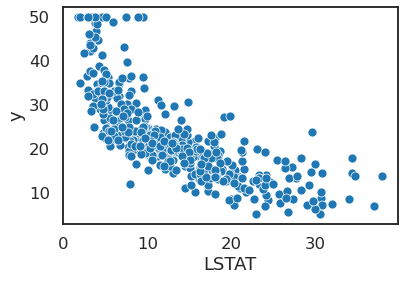

In [7]:
sns.scatterplot(data = df, x = 'LSTAT', y = 'y')

**Ejercicio 6: Divide el dataset en dos sub datasets, el de entreno y el de testeo con el 10% del tamaño total del dataset. Haz un grafico como el anterior con los diferentes datasets con colores distintos**


<AxesSubplot:xlabel='LSTAT', ylabel='y'>

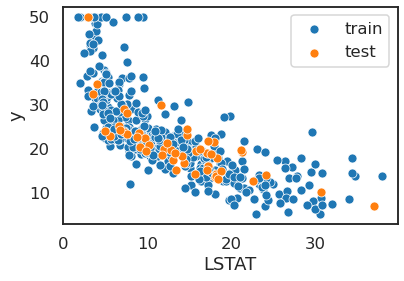

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,
                                     test_size = 0.10,
                                     random_state = 42)

sns.scatterplot(x='LSTAT', y='y', data=df_train, label='train')
sns.scatterplot(x='LSTAT', y='y', data=df_test, label='test')

**Ejercicio 7: Importa de la libreria sklearn los modelos elegidos anteriormente y entrenalos**

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Instancia las clases de los modelos importados
reg_DT = DecisionTreeRegressor()
reg_LR = LinearRegression()

## Define las variables de entrenamiento y la variable objetivo
feat_cols = ['LSTAT']
X_train = df_train[feat_cols]
y_train = df_train['y']

## Entrena los modelos

reg_DT.fit(X_train, y_train)
reg_LR.fit(X_train, y_train)

LinearRegression()

**Ejercicio 8: Evalúa el error producido dentro de la muestra de entreno para los dos algoritmos. Utiliza el RMSE**

In [12]:
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

y_hat_train_DT = reg_DT.predict(X_train)
y_hat_train_LR = reg_LR.predict(X_train)

in_sample_error_DT = RMSE(y_train, y_hat_train_DT)
in_sample_error_LR = RMSE(y_train, y_hat_train_LR)

print('In sample error for DT: {e} miles de $'.format(e=round(in_sample_error_DT, 2)))
print('In sample error for LR: {e} miles de $'.format(e= round(in_sample_error_LR, 2)))

In sample error for DT: 1.93 miles de $
In sample error for LR: 6.3 miles de $


**Ejercicio 9: Evalúa el error producido fuera de la muestra de entreno (datos de test) para los dos algoritmos. Utiliza el RMSE**

In [14]:
X_test = df_test[feat_cols]
y_test = df_test['y']

y_hat_test_DT = reg_DT.predict(X_test)
y_hat_test_LR = reg_LR.predict(X_test)

out_sample_error_DT = RMSE(y_test, y_hat_test_DT)
out_sample_error_LR = RMSE(y_test, y_hat_test_LR)

print('Out of sample error for DT: {e} miles de $'.format(e=round(out_sample_error_DT, 2)))
print('Out of sample error for LR: {e} miles de $'.format(e= round(out_sample_error_LR, 2)))

Out of sample error for DT: 4.67 miles de $
Out of sample error for LR: 5.25 miles de $


### Check point

Qué esta pasando?

Parece que un modelo simple de regresión lineal generaliza mejor que un modelo con un bies bajo? Cómo puede ser esto?

**Ejercicio 10: Haz una predicción para todos los valores que pueden tomar la variable de predicción** 

In [ ]:
# calcula el valor minimo del campo LSTAT
x_min = ##

# calcula el valor máximo del campo LSTAT
x_max = ##

# Crea un array de 200 elementos que vayan de manera uniforme entre los límites de LSTAT.
x = np.linspace(##, ##, 200)

# Haz un reshape de los valores usando .reshape(-1, 1). Nos evitará problemas con el resto de la librería.
x = x.reshape(-1, 1)

# Haz una predicción para los valores del array creado en el paso anterior para cada uno de los modelos
y_hat_DT = reg_DT.predict(x)
y_hat_LR = reg_LR.predict(x)

**Vamos a graficar los valores de entreno y test con las predicciones de cada uno de los modelos**

In [ ]:
# crea un subplot de dos columnas con un tamaño de 12 x 6
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

# Asigna al primer subplot los datos de entreno contra las predicciones de los dos modelos
ax[0].scatter(X_train, y_train, label='train', c='firebrick', alpha=0.5)
ax[0].plot(x, y_hat_DT, '*-', label='DT')
ax[0].plot(x, y_hat_LR, c='orange', label = 'LR')
ax[0].legend()

# Asigna al segundo subplot los datos de testeo contra las predicciones de los dos modelos
ax[1].scatter(X_test, y_test, label='test', c='green', alpha=0.5)
ax[1].plot(x, y_hat_DT, 'X-', label='DT')
ax[1].plot(x, y_hat_LR,  c='orange', label = 'LR')
ax[1].legend()

En efecto, lo que estamos observando aquí en directo es nada más ni nada menos que los efectos de *sub* y *sobre* entreno.

El arbol de decisión, al irse creando a medida que se entrena sobre los datos, se adapta demasiado bien a los datos de entreno y generaliza mal. En otras palabras, al aumentar su flexibilidad ha ido disminuyendo el error de *bies*, pero ha ido aumentando el error de *varianza*. Al aumentar el error de varianza es cuando los modelos generalizan mal, por que estan desmasiado adaptados a los datos de entrenamiento.

En el caso de los arboles de decision, podemos limitar su flexibilidad para evitar aumentar el error de varianza en exceso.

Uno de los hiper-parametros que nos permite "jugar" con la flexibilidad del modelo es la profundidad (max_depth). Vamos a echarle un vistazo más cercano.

**Ejercicio 12: Compara gráficamente como evoluciona el RMSE en función de la profundidad del arbol**

In [ ]:
max_depths = range(1, 20)
in_sample_errors = []
out_sample_errors = []
for max_depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=##).fit(##, ##)
    y_pred_train = tree.predict(X_train)
    y_pred_test = tree.predict(X_test)
    in_sample_error = ##
    out_sample_error = ##
    in_sample_errors.append(in_sample_error)
    out_sample_errors.append(out_sample_error)

plt.plot(max_depths, in_sample_errors, c='firebrick', label='In-Sample Error')
plt.plot(max_depths, out_sample_errors, label='Out-Sample Error')

plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.legend(loc='best')

En la gráfica de arriba, observamos como a partir de una profundidad de 4-5 el error `in-sample`, el que cometemos sobre el data set de entrenamiento continua disminuyendo. Estamos reduciendo error de bies. Sin embargo, el error `out-sample` empieza a aumentar a consecuencia de aumentar el error de varianza.

El punto óptimo, es conseguir el modelo que consigue minimizar el maximo de bies sin aumentar el error de varianza.

## Validación cruzada (cross-validation)
---
Ya hemos visto que el mejor modelo no es aquel que minimiza el error dentro de la muestra de entreno, si no que es aquel que minimiza el error de la **muestra de testeo**.

A pesar de que la división entre datos de entreno y datos de testeo da buenos resultados, es una aproximación básica que no nos permite afinar los hiperparametros de forma correcta. A base de afinar los hiperparametros evaluando el modelo en el set de testeo, podemos acabar incurriendon en una especie de "filtración" de la información de los datos de testeo al modelo. Con tal de evitar esto, en vez de dividir sólo en datos de entreno y testeo, deberíamos dividirlos en 3 partes: entreno, validación y test. De esta forma, podemos entrenar y refinar sobre los datos de entreno y validación para que una vez tengamos el modelo "afinado" podamos testearlo en el set de test.

<img src='img/trainvalidationtest.jpg'>

Esta aproximación, a pesar de ser correcta, implica ciertas limitaciones:

1. Reduce drásticamente el volumen de datos con el que estamos trabajando
1. No permite hacer "estadística" sobre los valores que obtenemos

Una forma de hacer frente a estas limitaciónes es mediante la técnica conocida cómo **validación cruzada**. Consiste en dividir el set de datos en $k$ partes iguales. Una vez hecho esto, podemos entrenar el modelo en $k-1$ y testear en aquella que hemos reservado. A esto se le llama *k-fold cross validation*. Entre sus variantes encontramos:

- **Stratified K-Fold Validation**: cada sub muestra mantiene la proporción de y's (clasificación)
- **Leave-One-Out**: Si $k=n$, dónde $n$ es el número de muestras que tenemos. Intensivo a nivel computacional

<img src='img/kfold.png'>

Echale un vistazo a la [documentación](http://scikit-learn.org/stable/modules/cross_validation.html)!


In [ ]:
from sklearn.model_selection import cross_val_score

DT_scores = cross_val_score(estimator=##,
                            X=##,
                            y=#,
                            cv=#,
                            scoring='neg_root_mean_squared_error') # Puedes consultar la lista de metrics para escorizar el modelo --> from sklearn.metrics import SCORERS; SCORERS.keys()

print('RMSE for DT: {m} +- {s}'.format(m=-round(DT_scores.mean(), 2),
                                       s=round(DT_scores.std(),2)))

In [1]:
from sklearn.metrics import SCORERS
SCORERS.keys()

**Ejercicio 13: Calcula el RMSE medio para la regresión lineal usando un k=5**

In [ ]:
LR_scores = cross_val_score(estimator=##,
                            X=##,
                            y=##,
                            cv=##,
                            scoring='neg_root_mean_squared_error')

print('RMSE for LR: {m} +- {s}'.format(m=-round(LR_scores.mean(), 2),
                                       s=round(LR_scores.std(),2)))

**Ejercicio 14: Grafica cómo evoluciona el RMSE medio para k=10, en comparación con los calculados en el ejercicio 12**

In [ ]:
# inicializa una lista vacia
cv_test_errors_mean = []
cv_test_errors_list = []

#itera sobre la lista de max_depths del ejercicio 12
for max_depth in max_depths:
    # Instancia el arbol
    tree = DecisionTreeRegressor(max_depth=##)
    
    # calcula el error usando cross_val_score y todo el set de datos.
    # Recuerda en negar el resultado
    cv_test_error = -cross_val_score(##,
                                     X=##,
                                     y=##,
                                     cv=5,
                                     scoring='neg_root_mean_squared_error')

    #calcula el valor medio y haz un append a la lista
    cv_test_errors_mean.append(cv_test_error.mean())
    
    # haz un append a la lista con todo el array de errores
    cv_test_errors_list.append(cv_test_error)

plt.plot(max_depths, in_sample_errors, c='firebrick', label='In-Sample Error')
plt.plot(max_depths, out_sample_errors, label='Out-Sample Error')
plt.plot(max_depths, cv_test_errors_mean, label='Cross-Validation Error')
plt.legend(loc='best')
                                 
errors = pd.DataFrame(cv_test_errors_list)                                 
for e in errors:
    plt.plot(max_depths, errors[e], c='gray', alpha=0.2)
plt.xlabel('max_depth')
plt.ylabel('RMSE')


# 2. Grid Search: ajuste de hiper-parametros.
---
Como hemos visto en el apartado anterior, podemos ajustar los hiper-parametros de ciertos modelos para aumentar o disminuir su "flexibilidad" a la hora de adaptarse a los datos y seleccionar el mejor a partir del resultado de la validación cruzada. Si repitieramos el ejercicio anterior para cada uno de los hiper-parametros del modelo podriamos afinar el modelo para poder exprimirlo completamente.

Podemos automátizar este proceso por fuerza bruta definiendo un espacio de busqueda sobre los distintos hiper-parametros que queremos probar y calculando el error cométido para cada una de las combinaciones.

Sklearn nos da una herramienta muy útil para tal propósito, GridSearchCV. Esta herramienta evaluará el modelo con cada una de las combinaciones de hiper-parametros utilizando la técnica del cross validation.

Veamos como usarla.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': ##, crea una lista con los posibles valores a probar de profundidad
          'min_samples_split': ##, crea una lista con los posibles valores a probar
          'min_samples_leaf': ## crea una lista con los posibles valores a probar
         }

reg = DecisionTreeRegressor()
gs_reg_DT = GridSearchCV(estimator=##,
                         param_grid=params,
                         cv=5,
                         scoring='neg_root_mean_squared_error')

gs_reg_DT.fit(df[['LSTAT']].values, df.y)
print(gs_reg_DT.best_params_)

**Ejercicio 15: Guarda en un dataframe los resultados de las iteraciones.**

Los encontraras en `gs_reg_DT.cv_results_`

In [ ]:
df_cv_results = pd.DataFrame(gs_reg_DT.cv_results_)

df_cv_results.head()

**Ejercicio 16: Compara graficamente el mejor modelo DT con la regresion lineal y el arbol de decision iniciales**

In [ ]:
plt.scatter(X_test, y_test, c='gray', alpha=0.5)
plt.plot(x, reg_LR.predict(x), c ='green', label='Linear Reg', alpha=0.5)
plt.plot(x, reg_DT.predict(x), c ='blue', label='Overfit DT', alpha=0.5)
plt.plot(x, gs_reg_DT.predict(x), c='firebrick', label='Fine tuned Decission Tree', alpha=0.5)
plt.xlabel('LSTAT')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()